In [26]:
## quick plotting function with adjustable vertical line to check readout at user-specified energies

import os
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy.signal import find_peaks
from ipywidgets import Text, fixed, VBox, Output

def view_chn_spectrum(filepath, a=0.2878, b=-9.14, prominence=500, width=600, show_line=True):
    def read_ortec_chn(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
        num_channels = struct.unpack('<H', data[20:22])[0]
        spectrum_data = struct.unpack('<' + 'H' * num_channels, data[32:32 + 2 * num_channels])
        full_counts = np.array(spectrum_data)

        # Use only the half that is non-zero
        if np.all(full_counts[::2] == 0):
            counts = full_counts[1::2]  # use odd bins
            offset = 1
        elif np.all(full_counts[1::2] == 0):
            counts = full_counts[::2]  # use even bins
            offset = 0
        else:
            counts = full_counts
            offset = 0

        return counts, offset

    def channel_to_energy(channels, a, b):
        return a * channels + b

    def plot_spectrum(counts, a, b, x_value, show_line):
        channels = np.arange(len(counts)) * 2 + offset
        energy = channel_to_energy(channels, a, b)

        # Snap to nearest bin
        index = np.argmin(np.abs(energy - x_value))
        snapped_energy = energy[index]
        value_at_x = counts[index]

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(energy, counts, label='Counts')
        ax.set_xlim(left=0, right=2000)
        ax.set_yscale('log')

        # Conditionally show red line and text
        if show_line:
            ax.axvline(x=snapped_energy, color='r', linestyle='--')
            ax.scatter(snapped_energy, value_at_x, color='r')
            ax.text(snapped_energy + 0.2, value_at_x + 0.1,
                    f'Value: {value_at_x:.2f}\nEnergy: {snapped_energy:.2f} keV',
                    color='r', fontsize=9)

        # Add labels, title, etc.
        ax.set_title(f'Spectrum from {filepath}')
        ax.set_xlabel('Energy (keV)')
        ax.set_ylabel('Counts')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

    # Load data
    counts, offset = read_ortec_chn(filepath)
    channels = np.arange(len(counts))
    energy = channel_to_energy(channels, a, b)
    energy_min, energy_max = energy[0], energy[-1]

    # Text box widget
    energy_text = Text(
        value=str(0),
        description='Energy:',
        continuous_update=False
    )

    out = Output()

    def update_plot(change):
        with out:
            out.clear_output()
            try:
                val = float(change['new'])
                if energy_min <= val <= energy_max:
                    plot_spectrum(counts, a, b, val, show_line)
            except ValueError:
                pass  # Invalid input — ignore

    energy_text.observe(update_plot, names='value')

    # Show initial plot
    with out:
        plot_spectrum(counts, a, b, float(energy_text.value), show_line)

    return VBox([energy_text, out])

In [28]:
folder = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\5-1-25"
files = [os.path.join(folder, file_path) for file_path in os.listdir(folder)]

for f in files:
    display(view_chn_spectrum(f, a=0.2878, b=-9.14, show_line=True));

In [25]:
## function to read out first 100 bins of .chn file

import struct
import numpy as np

def read_ortec_chn(filepath):
    with open(filepath, 'rb') as f:
        data = f.read()
    num_channels = struct.unpack('<H', data[20:22])[0]
    spectrum_data = struct.unpack('<' + 'H' * num_channels, data[32:32 + 2 * num_channels])
    return np.array(spectrum_data)

def channel_to_energy(channels, a, b):
    return a * channels + b

def print_first_100_bins(filepath, a=0.172, b=-5.92):
    counts = read_ortec_chn(filepath)
    channels = np.arange(len(counts))
    energy = channel_to_energy(channels, a, b)

    print(f"{'Channel':>7} {'Energy (keV)':>15} {'Counts':>10}")
    print('-' * 35)
    for ch in range(min(100, len(counts))):
        print(f"{ch:7d} {energy[ch]:15.3f} {counts[ch]:10d}")

# Example usage:
# Replace with the path to your .CHN file
filepath = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\4-30-25\\cs-137 (pb backing).Chn"
print_first_100_bins(filepath)

Channel    Energy (keV)     Counts
-----------------------------------
      0          -5.920          0
      1          -5.748          0
      2          -5.576          0
      3          -5.404          0
      4          -5.232          0
      5          -5.060          0
      6          -4.888          0
      7          -4.716          0
      8          -4.544          0
      9          -4.372          0
     10          -4.200          0
     11          -4.028          0
     12          -3.856          0
     13          -3.684          0
     14          -3.512          0
     15          -3.340          0
     16          -3.168          0
     17          -2.996          0
     18          -2.824          0
     19          -2.652          0
     20          -2.480          0
     21          -2.308          0
     22          -2.136          0
     23          -1.964          0
     24          -1.792          0
     25          -1.620          0
     26          -1

In [87]:
## function to fit gaussians and calculate uncertainties

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import struct
import matplotlib.cm as cm
from collections import defaultdict
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

# === Utility Functions ===

def read_ortec_chn(filepath):
    with open(filepath, 'rb') as f:
        data = f.read()
    num_channels = struct.unpack('<H', data[20:22])[0]
    spectrum_data = struct.unpack('<' + 'H' * num_channels, data[32:32 + 2 * num_channels])
    full_counts = np.array(spectrum_data)

    if np.all(full_counts[::2] == 0):
        counts = full_counts[1::2]
        offset = 1
    elif np.all(full_counts[1::2] == 0):
        counts = full_counts[::2]
        offset = 0
    else:
        counts = full_counts
        offset = 0

    return counts, offset

def get_runtime_seconds(filepath):
    with open(filepath, 'rb') as f:
        f.seek(14)
        live_time = struct.unpack('<f', f.read(4))[0]
    return live_time

def channel_to_energy(channels, a=0.2878, b=-9.14):
    return a * channels + b

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# === Core Logic ===

def process_and_plot_overlay(data_files, background_file, peak_expectations, title, sample_names, 
                             a=0.2878, b=-9.14, subtract_bkg=True, manual_lines=None,
                             window_kev=10, x_lim=1500, leg_loc='best', smoothing_sigma=None):
    if subtract_bkg:
        bkg_counts, _ = read_ortec_chn(background_file)
        bkg_runtime = get_runtime_seconds(background_file)

    plt.figure(figsize=(10, 6))
    plt.xlim(0, x_lim)

    colors = cm.get_cmap('tab10')
    sample_handles = []
    peak_handles = []
    peak_entries = []

    # To track which peaks have been fitted already
    fitted_peaks = set()

    for i, data_file in enumerate(data_files):
        sample_name = sample_names[i]
        data_counts, offset = read_ortec_chn(data_file)
        data_runtime = get_runtime_seconds(data_file)

        if subtract_bkg:
            scale = data_runtime / bkg_runtime
            net_counts = data_counts - bkg_counts * scale
            net_counts = np.clip(net_counts, 0, None)
        else:
            net_counts = data_counts

        # Optional smoothing
        if smoothing_sigma and smoothing_sigma > 0:
            net_counts = gaussian_filter1d(net_counts, sigma=smoothing_sigma)

        channels = np.arange(len(net_counts)) * 2 + offset
        energy = channel_to_energy(channels, a, b)

        label = f"{sample_name}"
        sample_plot, = plt.plot(energy, net_counts, label=label)
        sample_handles.append(sample_plot)

        expected_peaks = peak_expectations[i]

        for peak_guess_kev in expected_peaks:
            if peak_guess_kev in fitted_peaks:
                continue

            idx_min = np.argmin(np.abs(energy - (peak_guess_kev - window_kev)))
            idx_max = np.argmin(np.abs(energy - (peak_guess_kev + window_kev)))
            x_fit = energy[idx_min:idx_max]
            y_fit = net_counts[idx_min:idx_max]

            a0 = np.max(y_fit)
            x0 = x_fit[np.argmax(y_fit)]
            sigma0 = 2
            p0 = [a0, x0, sigma0]

            try:
                popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)

                center_energy = popt[1]
                sigma_energy = popt[2]
                center_uncertainty = np.sqrt(pcov[1, 1])
                sigma_uncertainty = np.sqrt(pcov[2, 2])

                fitted_peaks.add(peak_guess_kev)

                # Plot peak line
                color = colors(len(peak_entries) % 10)
                plt.axvline(center_energy, color=color, linestyle='--', linewidth=1.2)

                # Legend entry
                label = f"Peak at {center_energy:.1f} ± {center_uncertainty:.1f} keV, " \
                        f"$\\sigma$ = {sigma_energy:.1f} ± {sigma_uncertainty:.1f} keV"
                dashed_line = Line2D([0], [0], color=color, linestyle='--', label=label)
                peak_entries.append((center_energy, dashed_line))
            except RuntimeError:
                continue

    # Sort peak entries by center energy
    peak_entries.sort(key=lambda x: x[0])
    peak_handles = [entry[1] for entry in peak_entries]

    # === Optional manual vertical lines with labels ===
    if manual_lines:
        manual_cmap = cm.get_cmap('Set2')
        for idx, (x_val, label) in enumerate(manual_lines):
            color = manual_cmap(idx % manual_cmap.N)
            plt.axvline(x_val, color=color, linestyle='--', linewidth=1.5)
            manual_line = Line2D([0], [0], color=color, linestyle='--', linewidth=1.5, label=label)
            peak_handles.append(manual_line)

    # Combine sample, peak, and manual handles for the legend
    handles = sample_handles + peak_handles
    labels = [h.get_label() for h in handles]
    plt.legend(handles, labels, fontsize=12, loc=leg_loc)

    plt.xlabel('Energy (keV)', fontsize=16)
    plt.ylabel('Counts', fontsize=16)
    plt.title(title, fontsize=18)
    
    plt.yscale('log')
    plt.grid(False)
    plt.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.show()

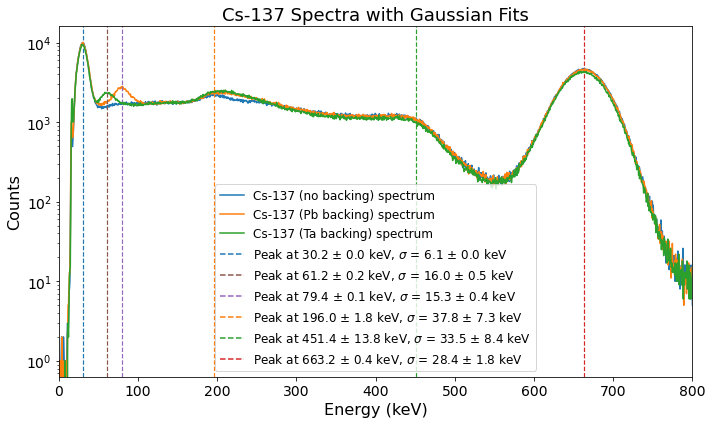

In [85]:
folder = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\4-30-25\\"
data_files = [
    folder + "cs-137 (no backing).chn",
    folder + "cs-137 (pb backing).chn",
    folder + "cs-137 (ta backing).chn"
]
background_file = folder + "bkg.chn"

# Expected peaks per sample: only try fitting each peak once
peak_expectations = [
    [30, 200, 480, 662],  # first sample
    [80],                 # second sample
    [60]                  # third sample
]

sample_names = [
    'Cs-137 (no backing) spectrum',
    'Cs-137 (Pb backing) spectrum',
    'Cs-137 (Ta backing) spectrum'
]

title = 'Cs-137 Spectra with Gaussian Fits'

process_and_plot_overlay(
    data_files, background_file, peak_expectations, title, sample_names,
    subtract_bkg=False,
    x_lim=800, smoothing_sigma=None
)

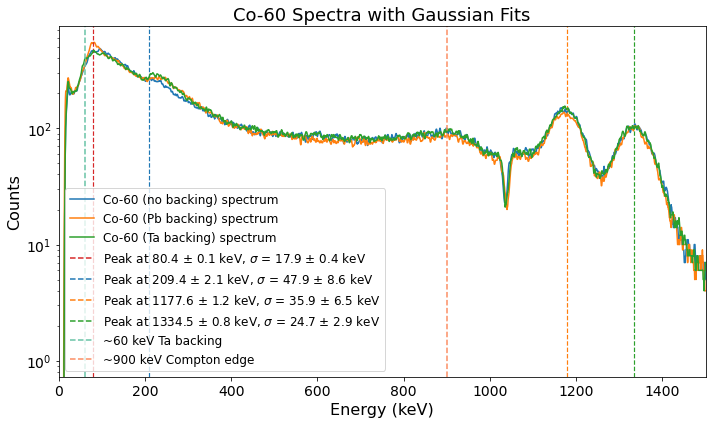

In [95]:
folder = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\4-30-25\\"
data_files = [
    folder + "co-60 (no backing).chn",
    folder + "co-60 (pb backing).chn",
    folder + "co-60 (ta backing).chn"
]
background_file = folder + "bkg.chn"

# Expected peaks per sample: only try fitting each peak once
peak_expectations = [
    [215, 1180, 1333],  # first sample, missing 1000
    [80],                 # second sample
    []                  # third sample, missing 60
]

manual_lines = [
    (60, "~60 keV Ta backing"),
    (900, "~900 keV Compton edge")
]

sample_names = [
    'Co-60 (no backing) spectrum',
    'Co-60 (Pb backing) spectrum',
    'Co-60 (Ta backing) spectrum'
]

title = 'Co-60 Spectra with Gaussian Fits'

process_and_plot_overlay(
    data_files, background_file, peak_expectations, title, sample_names,
    subtract_bkg=False, manual_lines=manual_lines,
    x_lim=1500, smoothing_sigma=2
)

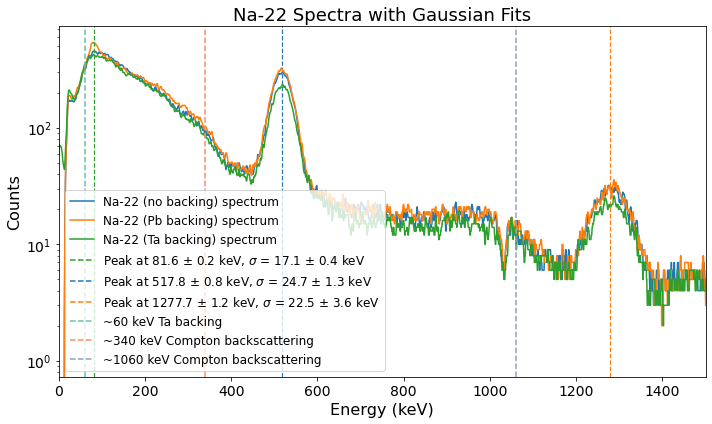

In [93]:
folder = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\4-30-25\\"
folder2 = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\5-1-25\\"
data_files = [
    folder2 + "na-22 (no backing).chn",
    folder2 + "na-22 (pb backing).chn",
    folder2 + "na-22 (ta backing).chn"
]
background_file = folder + "bkg.chn"

# Expected peaks per sample: only try fitting each peak once
peak_expectations = [
    [511, 1275],  # first sample, missing 340 and 1060
    [80],                 # second sample
    []                  # third sample, missing 60
]

manual_lines = [
    (60, "~60 keV Ta backing"),
    (340, "~340 keV Compton backscattering"),
    (1060, "~1060 keV Compton backscattering")
]

sample_names = [
    'Na-22 (no backing) spectrum',
    'Na-22 (Pb backing) spectrum',
    'Na-22 (Ta backing) spectrum'
]

title = 'Na-22 Spectra with Gaussian Fits'

process_and_plot_overlay(
    data_files, background_file, peak_expectations, title, sample_names,
    subtract_bkg=False, manual_lines=manual_lines,
    x_lim=1500, leg_loc='lower left', smoothing_sigma=2
)